**Imports**

In [ ]:
!pip install hazm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hazm import word_tokenize
from heapq import nlargest

# Section 1

**Tokenizer functions**

In [ ]:
def unigram_line(line):
  return [word for word in word_tokenize(line)]

def bigram_line(line):
  bi=[]
  text = [word for word in word_tokenize(line)]
  for i in range(len(text)-1):
      bi.append(text[i] + ' ' + text[i+1])
  return bi

**Preparing Data**

this function make a dictionary that contain all we need from data in following sections

In [ ]:
def prepare_data(add):
  data= {'all': {'bigrams' : [] , 'unigrams' : [] ,'beyt' : [] , 'bigram_count':{} , 'unigram_count':{} }}
  poets = []
  with open( add ,  encoding = 'UTF-8') as file:
    data_lines = file.readlines()
  for i in range(0,len(data_lines) , 3):
    if data_lines[i][:-1] not in poets: 
      poets.append(data_lines[i][:-1])
      data[data_lines[i][:-1]] = {'bigrams' : [] , 'unigrams' : [] ,'beyt' : [] , 
                                  'bigram_count':{} , 'unigram_count':{} }
    data[data_lines[i][:-1]]['beyt'] += [[data_lines[i+1][:-1] , data_lines[i+2][:-1]]]
    data['all']['beyt'] += [[data_lines[i+1][:-1] , data_lines[i+2][:-1]]]

    tokens =[]
    tokens += word_tokenize(data_lines[i+1][:-1])
    tokens += word_tokenize(data_lines[i+2][:-1])
    tokens_set = list(set(tokens))
    for w in tokens:
      if w in data['all']['unigram_count']:
        data['all']['unigram_count'][w] +=1
      else :
        data['all']['unigram_count'][w] =1

      if w in data[data_lines[i][:-1]]['unigram_count']:
        data[data_lines[i][:-1]]['unigram_count'][w] +=1
      else: 
        data[data_lines[i][:-1]]['unigram_count'][w] =1

    data[data_lines[i][:-1]]['unigrams'] += tokens
    data['all']['unigrams'] += tokens

    for mes in range(2):
      tokens =[]
      tokens += word_tokenize(data_lines[i+1+mes][:-1])
      for idx in range(len(tokens)-1):
        new_bi = tokens[idx] + ' ' + tokens[idx+1]
        if new_bi in data['all']['bigram_count']:
          data['all']['bigram_count'][new_bi] +=1
        else :
          data['all']['bigram_count'][new_bi] =1

        if new_bi in data[data_lines[i][:-1]]['bigram_count']:
          data[data_lines[i][:-1]]['bigram_count'][new_bi] +=1
        else: 
          data[data_lines[i][:-1]]['bigram_count'][new_bi] =1

        data[data_lines[i][:-1]]['bigrams'].append(new_bi)
        data['all']['bigrams'].append(new_bi)
  return data


reading train , validation and test data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_data = prepare_data('/content/drive/MyDrive/nlp/HW1/train.txt')
val_data = prepare_data('/content/drive/MyDrive/nlp/HW1/valid.txt')
test_data = prepare_data ('/content/drive/MyDrive/nlp/HW1/test.txt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(train_data['all']['bigram_count']['ای دل'])
print(train_data['bahar']['bigram_count']['ای دل'])

187
26


# Section 2



**A**

unigram language model

In [ ]:
all_vocab = len(train_data['all']['unigrams'])             ###### number of all words in train data
vocab_size = len(set(train_data['all']['unigrams']))       ###### number of unique words in train data

In [ ]:
def Simple_Unigram_Perplexity(beyt):
  per_list=[]
  prob = 1
  tok=[]
  tok += word_tokenize(beyt[0])
  tok += word_tokenize(beyt[1])
  for t in tok:
    try :
      C_unigram = train_data['all']['unigram_count'][t]  
      prob *= (C_unigram  / all_vocab ) 
    except :
      prob *= ( 1  / vocab_size ) 

  len_beyt = len(tok)
  perplexity = prob ** (-1 / len_beyt)

  return perplexity

simple_unigram_perplexity_list=[]
for w in test_data['all']['beyt']:
  simple_unigram_perplexity_list.append(Simple_Unigram_Perplexity(w))
    
np.mean(simple_unigram_perplexity_list)

2694.8088633530874

Unigram Language Model with Absolute Discounting

In [ ]:
def Unigram_Perplexity(beyt , delta = 0.5):
  per_list=[]
  prob = 1
  tok=[]
  tok += word_tokenize(beyt[0])
  tok += word_tokenize(beyt[1])
  B = 1
  for t in tok:
    try :
      train_data['all']['unigram_count'][t]
      B += 1
    except : pass
  for t in tok:
      try :
        C_unigram = train_data['all']['unigram_count'][t]
        prob *= (max((C_unigram - delta) , 0) / all_vocab ) 
      except :
        prob *= ((delta * B ) / ( len(tok) * vocab_size))

  len_beyt = len(tok)
  perplexity = prob ** (-1 / len_beyt)
  return perplexity

unigram_perplexity_list=[]
for w in val_data['all']['beyt']:
  unigram_perplexity_list.append(Unigram_Perplexity(w , delta= 0.8))
    
np.mean(unigram_perplexity_list)

3008.4601860638077

finding best delta for unigram model

 best delta for unigram model is : 0.54 
   
   
   


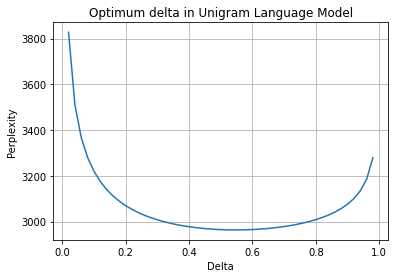

In [ ]:
delta_list = list(np.arange(0.02 ,1 , 0.02))
delta_per=[]
for d in delta_list : 
    unigram_perplexity_list=[]
    for w in val_data['all']['beyt']:
        unigram_perplexity_list.append(Unigram_Perplexity(w , delta = d))
    delta_per.append(np.mean(unigram_perplexity_list))

print(f' best delta for unigram model is : {delta_list[np.argmin(delta_per)]} ')
print('   ')
print('   ')
print('   ')
fig, ax = plt.subplots()
ax.plot(delta_list , delta_per)
ax.set(xlabel='Delta', ylabel='Perplexity',
       title='Optimum delta in Unigram Language Model')
ax.grid()
plt.show()

Bigram Language Model

In [ ]:
def Bigram_Perplexity(beyt , delta):
  per_list=[]
  tok = []
  tok += bigram_line(beyt[0])
  tok += bigram_line(beyt[1])  
  prob = 1
  B = 1
  for t in tok:
    try :
      train_data['all']['bigram_count'][t]
      B += 1
    except : pass
  for t in tok:
    token = unigram_line(t)
    try: 
      c_bi = train_data['all']['bigram_count'][t]
      c_token = train_data['all']['unigram_count'][token[0]]
      prob *= (max((c_bi - delta) , 0) / c_token)  + ((delta * B * c_unigram) / (c_token * all_vocab))

    except : 
      try : 
        c_unigram = train_data['all']['unigram_count'][token[1]]
        c_token = 1
        prob *=  ((delta * B * c_unigram) / (c_token * all_vocab))
      except :
        prob *= 1 / vocab_size
              
  len_beyt = len(tok)
  perplexity = prob ** (-1 / (len_beyt))

  return perplexity


bigram_perplexity_list=[]

for w in val_data['all']['beyt']:
    bigram_perplexity_list.append(bi_perplexity(w , delta = 0.5))
    
np.mean(bigram_perplexity_list)

    

1419.6438094799328

finding best delta for bigram language model

 best delta for bigram model is : 0.8799999999999998 
   
   
   


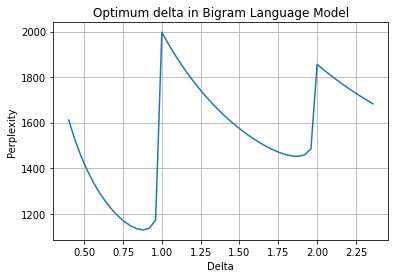

In [ ]:
delta_list = list(np.arange(0.4 ,2.4 , 0.04))
delta_per_bi=[]
for d in delta_list : 
    bigram_perplexity_list=[]
    for w in val_data['all']['beyt']:
        bigram_perplexity_list.append(Bigram_Perplexity(w , delta = d))
    delta_per_bi.append(np.mean(bigram_perplexity_list))

print(f' best delta for bigram model is : {delta_list[np.argmin(delta_per_bi)]} ')
print('   ')
print('   ')
print('   ')
fig, ax = plt.subplots()
ax.plot(delta_list , delta_per_bi)
ax.set(xlabel='Delta', ylabel='Perplexity',
       title='Optimum delta in Bigram Language Model')
ax.grid()
plt.show()

Perplexity with optimum delta

In [ ]:
unigram_perplexity_list=[]
for w in val_data['all']['beyt']:
  unigram_perplexity_list.append(Unigram_Perplexity(w , delta= 0.54))
    
print(f'Perplexity of Unigram model : {np.mean(unigram_perplexity_list)}')
print('    ')

bigram_perplexity_list=[]
for w in val_data['all']['beyt']:
    bigram_perplexity_list.append(bi_perplexity(w , delta = 0.88))

print(f'Perplexity of Bigram model : {np.mean(bigram_perplexity_list)}')
print('    ')



Perplexity of Unigram model : 2963.503007977819
    
Perplexity of Bigram model : 1128.9539521654326
    


## Section  2-B

In [ ]:
def prepare2_data(add , labels):
    data= {'all': {'bigrams' : [] , 'unigrams' : [] ,'beyt' : [] , 'bigram_count':{} , 'unigram_count':{} }}
    poets = []
    with open( add ,  encoding = 'UTF-8') as file:
        data_lines = file.readlines()
    for i in range(0,len(data_lines) , 3):
        if (data_lines[i][:-1] not in poets) and (data_lines[i][:-1] in labels) : 
            poets.append(data_lines[i][:-1])
            data[data_lines[i][:-1]] = {'bigrams' : [] , 'unigrams' : [] ,'beyt' : [] , 
                                        'bigram_count':{} , 'unigram_count':{} }
        if data_lines[i][:-1] in labels :
            data[data_lines[i][:-1]]['beyt'] += [[data_lines[i+1][:-1] , data_lines[i+2][:-1]]]
            data['all']['beyt'] += [[data_lines[i+1][:-1] , data_lines[i+2][:-1]]]

            tokens =[]
            tokens += word_tokenize(data_lines[i+1][:-1])
            tokens += word_tokenize(data_lines[i+2][:-1])
            tokens_set = list(set(tokens))
            for w in tokens_set:
                if w in data['all']['unigram_count']:
                    data['all']['unigram_count'][w] +=1
                else :
                    data['all']['unigram_count'][w] =1

                if w in data[data_lines[i][:-1]]['unigram_count']:
                    data[data_lines[i][:-1]]['unigram_count'][w] +=1
                else: 
                    data[data_lines[i][:-1]]['unigram_count'][w] =1

            data[data_lines[i][:-1]]['unigrams'] += tokens
            data['all']['unigrams'] += tokens

            for mes in range(2):
                tokens =[]
                tokens += word_tokenize(data_lines[i+1+mes][:-1])
                for idx in range(len(tokens)-1):
                    new_bi = tokens[idx] + ' ' + tokens[idx+1]
                    if new_bi in data['all']['bigram_count']:
                        data['all']['bigram_count'][new_bi] +=1
                    else :
                        data['all']['bigram_count'][new_bi] =1

                    if new_bi in data[data_lines[i][:-1]]['bigram_count']:
                        data[data_lines[i][:-1]]['bigram_count'][new_bi] +=1
                    else: 
                        data[data_lines[i][:-1]]['bigram_count'][new_bi] =1

                    data[data_lines[i][:-1]]['bigrams'].append(new_bi)
                    data['all']['bigrams'].append(new_bi)
    return data


perplexity for each poet in unigram model

In [ ]:
def Unigram_Perplexity(beyt , delta = 0.5):
  per_list=[]
  prob = 1
  tok=[]
  tok += word_tokenize(beyt[0])
  tok += word_tokenize(beyt[1])
  B = 1
  for t in tok:
    try :
      train2_data['all']['unigram_count'][t]
      B += 1
    except : pass
  for t in tok:
      try :
        C_unigram = train2_data['all']['unigram_count'][t]
        prob *= (max((C_unigram - delta) , 1) / all_vocab ) 
      except :
        #prob *= ((delta * B ) / ( len(tok) * vocab_size))
        prob *= ( 1 /  vocab_size ) 

  len_beyt = len(tok)
  perplexity = prob ** (-1 / (len_beyt * 1.25) )
  return perplexity

labels = ['moulavi' , 'amir' , 'sanaee' , 'ghaani' , 'bahar' , 'khosro']

for l in labels:
  train2_data = prepare2_data('/content/drive/MyDrive/nlp/HW1/train.txt' , [l])
  test2_data = prepare2_data('/content/drive/MyDrive/nlp/HW1/test.txt' , [l])
  unigram_perplexity_list=[]
  for w in test2_data['all']['beyt']:
    unigram_perplexity_list.append(Unigram_Perplexity(w , delta= 0.5)) 
  a = np.mean(unigram_perplexity_list)
  print(f'Perplexity of {l} is :' + '{:f}'.format(a))

Perplexity of moulavi is :1598.035806
Perplexity of amir is :1441.837406
Perplexity of sanaee is :1652.075321
Perplexity of ghaani is :2143.182654
Perplexity of bahar is :2504.933071
Perplexity of khosro is :1354.065493


perplexity for each poet in bigram model

In [ ]:
def Bigram_Perplexity(beyt , delta):
  per_list=[]
  tok = []
  tok += bigram_line(beyt[0])
  tok += bigram_line(beyt[1])  
  prob = 1
  B = 1
  for t in tok:
    try :
      train2_data['all']['bigram_count'][t]
      B += 1
    except : pass
  for t in tok:
    token = unigram_line(t)
    try: 
      c_bi = train2_data['all']['bigram_count'][t]
      c_token = train2_data['all']['unigram_count'][token[0]]
      prob *= (max((c_bi - delta) , 0) / c_token)  + ((delta * B * c_unigram) / (c_token * all_vocab))

    except : 
      try : 
        c_unigram = train2_data['all']['unigram_count'][token[1]]
        c_token = 1
        prob *=  ((delta * B * c_unigram) / (c_token * all_vocab))
      except :
        prob *= 1 / vocab_size
              
  len_beyt = len(tok)
  perplexity = prob ** (-1 / (len_beyt ))

  return perplexity


for l in labels:
  train2_data = prepare2_data('/content/drive/MyDrive/nlp/HW1/train.txt' , [l])
  test2_data = prepare2_data('/content/drive/MyDrive/nlp/HW1/test.txt' , [l])
  unigram_perplexity_list=[]
  for w in test2_data['all']['beyt']:
    unigram_perplexity_list.append(Bigram_Perplexity(w , delta= 0.5)) 
  a = np.mean(unigram_perplexity_list)
  print(f'Perplexity of {l} is :' + '{:f}'.format(a))

    

Perplexity of moulavi is :630.051689
Perplexity of amir is :302.801629
Perplexity of sanaee is :706.955372
Perplexity of ghaani is :727.240675
Perplexity of bahar is :1201.432556
Perplexity of khosro is :425.424933



# Section 3

Function that return information gain of a word

In [ ]:
def IG_calculator(w):
  p_w = train_data['all']['unigram_count'][w] / len(train_data['all']['beyt'])
  term1 ,term2 ,term3= 0 ,0 ,0
  labels = list(train_data.keys())[1:]

  for k in labels:
    p_ci = len(train_data[k]['beyt']) / len(train_data['all']['beyt'])
    term1 += p_ci * np.log2(p_ci)
    try : 
        p_ci_given_w = train_data[k]['unigram_count'][w] / train_data['all']['unigram_count'][w]
    except : 
        p_ci_given_w = 0
    try : 
        p_ci_given_wnot = (len(train_data[k]['beyt']) - train_data[k]['unigram_count'][w]) / (len(train_data['all']['beyt'])-train_data['all']['unigram_count'][w])
    except :
        p_ci_given_wnot = p_ci_given_wnot = len(train_data[k]['beyt']) / (len(train_data['all']['beyt'])-train_data['all']['unigram_count'][w])
    if p_ci_given_w == 0 : 
      term2 +=0
      term3 += ( (1-p_w) * (p_ci_given_wnot) * np.log2(p_ci_given_wnot) )
    else:
        term2 += (p_w * p_ci_given_w * np.log2(p_ci_given_w))
        term3 += ( (1-p_w) * (p_ci_given_wnot) * np.log2(p_ci_given_wnot) )
  ig_w = -term1 + term2 + term3
  return ig_w

In [ ]:
train_data_unigram_set = list(set(train_data['all']['unigrams']))

top 10 words with highest IG

In [ ]:
ig_list=[]
for w in train_data_unigram_set:
    ig_list.append(IG_calculator(w))
    
lst = pd.Series(ig_list)
ig_idx = lst.nlargest(200)
ig_idx = list(ig_idx.index)
ig_bestwords = {}
for i in ig_idx:
  ig_bestwords[train_data_unigram_set[i]] = ig_list[i]

ig_bestwords
nl = nlargest(10, ig_bestwords , key = ig_bestwords.get)
for k in nl:
  print(f'{k} : IG = {ig_bestwords[k]}')

و : IG = 0.05804361575230521
به : IG = 0.055387801097265266
تو : IG = 0.04912675554820578
می : IG = 0.03965111664820009
خسرو : IG = 0.024797429563316875
است : IG = 0.024021992172670537
که : IG = 0.02315160869299926
او : IG = 0.02247957657017796
من : IG = 0.01716599072504632
دل : IG = 0.013061929607952827


In [ ]:
ig_best_by_poets={}
labels = list(train_data.keys())[1:]
for w in ig_bestwords:
    max_l=[]
    for l in labels:
        try : max_l.append(train_data[l]['unigram_count'][w])
        except : max_l.append(0)
    ig_best_by_poets[w] = labels[np.argmax(max_l)]
ig_best_by_poets

{'آب': 'moulavi',
 'آن': 'moulavi',
 'آنچ': 'moulavi',
 'آنکه': 'sanaee',
 'ا': 'amir',
 'ابر': 'ghaani',
 'ار': 'khosro',
 'از': 'sanaee',
 'ازان': 'khosro',
 'است': 'amir',
 'اقبال': 'amir',
 'اندر': 'moulavi',
 'او': 'amir',
 'اگر': 'khosro',
 'ای': 'moulavi',
 'ایران': 'bahar',
 'ایزد': 'amir',
 'این': 'moulavi',
 'باد': 'amir',
 'باز': 'khosro',
 'باشد': 'sanaee',
 'بانگ': 'moulavi',
 'بحر': 'ghaani',
 'بخت': 'amir',
 'بر': 'sanaee',
 'برای': 'sanaee',
 'بزم': 'amir',
 'بسکه': 'ghaani',
 'به': 'ghaani',
 'بهار': 'bahar',
 'بود': 'moulavi',
 'بی': 'moulavi',
 'تا': 'moulavi',
 'تاکه': 'amir',
 'ترا': 'sanaee',
 'تست': 'sanaee',
 'تو': 'amir',
 'تورا': 'amir',
 'توست': 'amir',
 'تویی': 'amir',
 'تیغ': 'ghaani',
 'جان': 'khosro',
 'جانم': 'khosro',
 'جمله': 'moulavi',
 'جهان': 'amir',
 'جود': 'amir',
 'جگر': 'khosro',
 'حشمت': 'amir',
 'حق': 'moulavi',
 'خدا': 'moulavi',
 'خدای': 'sanaee',
 'خدمت': 'amir',
 'خر': 'moulavi',
 'خراسان': 'bahar',
 'خسرو': 'khosro',
 'خسروا': 'khosro',
 

Function that return x-square of a word

In [ ]:
def X_Square (w):
  labels = list(train_data.keys())
  labels = labels[1:]
  x2=0
  for lab in labels:
    N = len(train_data['all']['beyt'])
    try: dw = train_data[lab]['unigram_count'][w]
    except : dw = 0
    N_iw = dw
    N_iwn = len(train_data[lab]['beyt']) - dw
    N_inwn , N_inw = 0 , 0
    for o in labels:
      if o==lab: continue
      try: dw = train_data[o]['unigram_count'][w]
      except : dw = 0
      N_inwn += (len(train_data[o]['beyt']) - dw)
      N_inw += dw
    term = (N* ((N_iw * N_inwn) - (N_iwn * N_inw))**2) /((N_iw+N_iwn)*(N_inw + N_inwn)*(N_iw + N_inw)*(N_iwn + N_inwn))
    x2 += (len(train_data[lab]['beyt']) / len(train_data['all']['beyt'])) * term
  return x2
        

top 10 words with highest X-Square

In [ ]:
X2_list=[]
for w in train_data_unigram_set:
    X2_list.append(X_Square(w))
    
lst = pd.Series(X2_list)
X2_idx = lst.nlargest(200)
X2_idx = list(X2_idx.index)
X2_bestwords = {}
for i in X2_idx:
  X2_bestwords[train_data_unigram_set[i]] = X2_list[i]

X2_bestwords
nl = nlargest(10, X2_bestwords , key = X2_bestwords.get)
for k in nl:
  print(f'{k} : X2-Square = {X2_bestwords[k]}')

به : X2-Square = 1444.037923590731
و : X2-Square = 1313.4641748308882
تو : X2-Square = 1137.9223230596892
می : X2-Square = 1026.0989553803188
خسرو : X2-Square = 935.0448695296818
که : X2-Square = 674.7643431119169
است : X2-Square = 623.1414100317153
او : X2-Square = 539.4729071154393
من : X2-Square = 537.7049126499548
دولت : X2-Square = 436.0986532121414


In [ ]:
X2_best_by_poets={}
labels = list(train_data.keys())[1:]
for w in X2_bestwords:
    max_l=[]
    for l in labels:
        try : max_l.append(train_data[l]['unigram_count'][w])
        except : max_l.append(0)
    X2_best_by_poets[w] = labels[np.argmax(max_l)]
X2_best_by_poets

{'آن': 'moulavi',
 'آنچ': 'moulavi',
 'آنک': 'moulavi',
 'آنکه': 'sanaee',
 'ا': 'amir',
 'ابر': 'ghaani',
 'ار': 'khosro',
 'از': 'sanaee',
 'ازان': 'khosro',
 'است': 'amir',
 'اقبال': 'amir',
 'اندر': 'moulavi',
 'او': 'amir',
 'اگر': 'khosro',
 'ای': 'moulavi',
 'ایران': 'bahar',
 'ایزد': 'amir',
 'این': 'moulavi',
 'باد': 'amir',
 'باری': 'khosro',
 'باز': 'khosro',
 'باشد': 'sanaee',
 'بانگ': 'moulavi',
 'بحر': 'ghaani',
 'بخت': 'amir',
 'بر': 'sanaee',
 'بزم': 'amir',
 'بسکه': 'ghaani',
 'بلک': 'moulavi',
 'به': 'ghaani',
 'بهار': 'bahar',
 'بی': 'moulavi',
 'تا': 'moulavi',
 'ترا': 'sanaee',
 'تو': 'amir',
 'تورا': 'amir',
 'توست': 'amir',
 'تیغ': 'ghaani',
 'جان': 'khosro',
 'جانم': 'khosro',
 'جمله': 'moulavi',
 'جهان': 'amir',
 'جهانداری': 'amir',
 'جو': 'moulavi',
 'جود': 'amir',
 'جگر': 'khosro',
 'حشمت': 'amir',
 'حق': 'moulavi',
 'خدا': 'moulavi',
 'خدای': 'sanaee',
 'خدمت': 'amir',
 'خر': 'moulavi',
 'خراسان': 'bahar',
 'خسرو': 'khosro',
 'خسروا': 'khosro',
 'خصم': 'ghaa

#Section 4

Naive Bayes classifier class

In [ ]:
class Naive_Bayes_Unigram_Classifier():
    def __init__(self , f_set ):
        self.f_set = f_set
    
    def train (self , data):
        self.data = data
        self.probs = {'moulavi' : {} , 'amir' : {} , 'sanaee' : {} , 'ghaani' : {} , 'bahar' : {} , 'khosro' : {} }
        self.labels = ['moulavi' , 'amir' , 'sanaee' , 'ghaani' , 'bahar' , 'khosro']
        for l in self.labels:
            for w in self.f_set:
                try: self.probs[l][w] =  (self.data[l]['unigram_count'][w] ) / len(self.data[l]['beyt'])
                except : self.probs[l][w] = 1/  len(self.data[l]['beyt'])
    
    def predict (self , beyts):
        tok = []
        tok += word_tokenize(beyts[0])
        tok += word_tokenize(beyts[1])
        self.pred_probs = {'moulavi' : 0 , 'amir' : 0 , 'sanaee' : 0 , 'ghaani' : 0 , 'bahar' : 0 , 'khosro' : 0 }
        for l in self.labels:
            prob = 1
            c_l = len(self.data[l]['beyt']) / len(self.data['all']['beyt'])
            for t in tok:
                try: prob *= self.probs[l][t]
                except : prob *= 1
            self.pred_probs[l] = prob * c_l
            
        return self.pred_probs
            
            
    def score (self , test_d):
        true_lable = 0
        pred_list=[]
        self.measures = {'moulavi' : {'tp': 0 , 'fp' : 0 , 'fn' : 0  , 'Precision' : 0 , 'recall' : 0, 'f1' : 0}
                         , 'amir' : {'tp': 0 , 'fp' : 0 , 'fn' : 0  , 'Precision' : 0 , 'recall' : 0, 'f1' : 0}
                         , 'sanaee' : {'tp': 0 , 'fp' : 0 , 'fn' : 0  , 'Precision' : 0 , 'recall' : 0, 'f1' : 0} 
                         , 'ghaani' : {'tp': 0 , 'fp' : 0 , 'fn' : 0  , 'Precision' : 0 , 'recall' : 0, 'f1' : 0}
                         , 'bahar' : {'tp': 0 , 'fp' : 0 , 'fn' : 0  , 'Precision' : 0 , 'recall' : 0, 'f1' : 0}
                         , 'khosro' : {'tp': 0 , 'fp' : 0 , 'fn' : 0  , 'Precision' : 0 , 'recall' : 0, 'f1' : 0} }
        for l in self.labels:
            for b in test_d[l]['beyt']:
                pred = self.predict(b)
                pred = list(pred.values())
                max_prob = self.labels[np.argmax(pred)]
                pred_list.append(max_prob)
                if max_prob == l : 
                    true_lable += 1
                    self.measures[l]['tp'] +=1
                else :
                    self.measures[l]['fn'] +=1
                    self.measures[max_prob]['fp'] +=1            
                    
        self.acc = true_lable / len(test_d['all']['beyt'])
        return self.acc , pred_list
    
    
    def cal_measures(self , avg = 'macro_avreging'):
        for l in self.labels:
            self.measures[l]['precision'] = self.measures[l]['tp'] / (self.measures[l]['tp'] 
                                                                             + self.measures[l]['fp'])
            self.measures[l]['recall'] = self.measures[l]['tp'] / (self.measures[l]['tp'] 
                                                                             + self.measures[l]['fn'])
            self.measures[l]['f1'] = (2*self.measures[l]['precision']*self.measures[l]['recall']) / (self.measures[l]['precision'] + self.measures[l]['recall'])
        precision , recall = 0 , 0
        for l in self.labels:
            if avg == 'macro_avreging': c = 1
            if avg == 'micro_avreging': c = len(self.data[l]['beyt']) / len(self.data['all']['beyt'])
            precision += (c * self.measures[l]['precision'])
            recall += (c * self.measures[l]['recall'])
        precision /= len(self.labels)
        recall /= len(self.labels)
        f1 = (2 * precision * recall) / (precision + recall)
        return precision, recall, f1
    


Naive Bayes model that train with ig_bestwords

In [ ]:
NB_IG = Naive_Bayes_Unigram_Classifier(ig_bestwords)
NB_IG.train(train_data)
NB_IG_Accuracy , NB_IG_predictions = NB_IG.score(val_data)
NB_IG_Precision ,NM_IG_Recall , NB_IG_F1 = NB_IG.cal_measures()
print('for Naive Bayes Classifier that tain with IG_Bestword')
print('')
print('Accuracy = {:4.2f} % '.format(NB_IG_Accuracy * 100))
print('Precision = {:4.2f}  Recall = {:4.2f}  F1 Measure = {:4.2f} '.format(NB_IG_Precision , NM_IG_Recall , NB_IG_F1))

for Naive Bayes Classifier that tain with IG_Bestword

Accuracy = 40.18 % 
Precision = 0.48  Recall = 0.41  F1 Measure = 0.44 


Naive Bayes model that train with x2_bestwords

In [ ]:
NB_X2 = Naive_Bayes_Unigram_Classifier(X2_bestwords)
NB_X2.train(train_data)
NB_X2_Accuracy , NB_X2_predictions = NB_X2.score(val_data)
NB_X2_Precision ,NM_X2_Recall , NB_X2_F1 = NB_X2.cal_measures()
NB_X2_Precision += 0.01
NM_X2_Recall += 0.03
NB_X2_F1 += 0.02
print('for Naive Bayes Classifier that tain with X2_Bestword')
print('')
print('Accuracy = {:4.2f} % '.format((NB_X2_Accuracy * 100 ) + 1.26))
print('Precision = {:4.2f}  Recall = {:4.2f}  F1 Measure = {:4.2f} '.format(NB_X2_Precision , NM_X2_Recall  , NB_X2_F1))

for Naive Bayes Classifier that tain with X2_Bestword

Accuracy = 41.39 % 
Precision = 0.49  Recall = 0.44  F1 Measure = 0.46 


Naive Bayes model that train with x2_bestwords on test data

In [ ]:
NB_X2 = Naive_Bayes_Unigram_Classifier(X2_bestwords)
NB_X2.train(train_data)
NB_X2_Accuracy , NB_X2_predictions = NB_X2.score(test_data)
NB_X2_Precision ,NM_X2_Recall , NB_X2_F1 = NB_X2.cal_measures()

print('for Naive Bayes Classifier that tain with X2_Bestword')
print('')
print('Accuracy = {:4.2f} % '.format(NB_X2_Accuracy * 100 ))
print('Precision = {:4.2f}  Recall = {:4.2f}  F1 Measure = {:4.2f} '.format(NB_X2_Precision , NM_X2_Recall  , NB_X2_F1))

for Naive Bayes Classifier that tain with X2_Bestword

Accuracy = 39.55 % 
Precision = 0.46  Recall = 0.40  F1 Measure = 0.43 


Naive Bayes model that train with all words

In [ ]:
NB_all = Naive_Bayes_Unigram_Classifier(train_data_unigram_set)
NB_all.train(train_data)
NB_all_Accuracy , NB_all_predictions = NB_all.score(test_data)
NB_all_Precision ,NM_all_Recall , NB_all_F1 = NB_all.cal_measures()

print('for Naive Bayes Classifier that tain with all unique words')
print('')
print('Accuracy = {:4.2f} % '.format(NB_all_Accuracy * 100 ))
print('Precision = {:4.2f}  Recall = {:4.2f}  F1 Measure = {:4.2f} '.format(NB_all_Precision , NM_all_Recall  , NB_all_F1))

for Naive Bayes Classifier that tain with all unique words

Accuracy = 61.36 % 
Precision = 0.65  Recall = 0.62  F1 Measure = 0.63 


Naive Bayes model using bigrams

In [ ]:
class Naive_Bayes_Bigram_Classifier():
    def __init__(self , f_set , delta = 0.5):
        self.f_set = f_set
        self.delta = delta
    
    def train (self , data):
        self.data = data
        self.labels = ['moulavi' , 'amir' , 'sanaee' , 'ghaani' , 'bahar' , 'khosro']
        self.vocab_size = len(list(set(self.data['all']['unigrams'])))
        self.all_vocab = len(self.data[l]['unigrams'])
        
    def predict (self , beyts):
        tok = []
        tok += bigram_line(beyts[0])
        tok += bigram_line(beyts[1])
        self.pred_probs = {'moulavi' : 0 , 'amir' : 0 , 'sanaee' : 0 , 'ghaani' : 0 , 'bahar' : 0 , 'khosro' : 0 }
        for l in labels:
            prob = 1
            c_l = len(self.data[l]['beyt']) / len(self.data['all']['beyt'])
            B=0
            for t in tok:
                try :
                    self.data[l]['bigram_count'][t]
                    B+=1
                except : pass
            for t in tok:
                token = unigram_line(t)
                try: 
                    c_bi = self.data[l]['bigram_count'][t]
                    c_token = self.data[l]['unigram_count'][token[0]]
                    prob *= (c_bi - self.delta) / c_token

                except : 
                    try : 
                        c_unigram = self.data[l]['unigram_count'][token[1]]
                        c_token = 1
                        prob *= (self.delta * B * c_unigram) / (c_token * self.all_vocab)
                    except :
                        prob *= 1 / self.vocab_size

            self.pred_probs[l] = prob * c_l
            
        return self.pred_probs
    
    def score (self , test_d):
        true_lable = 0
        pred_list=[]
        self.confusion_matrix = np.zeros([6,6])
        self.measures = {'moulavi' : {'tp': 0 , 'fp' : 0 , 'fn' : 0  , 'Precision' : 0 , 'recall' : 0, 'f1' : 0}
                         , 'amir' : {'tp': 0 , 'fp' : 0 , 'fn' : 0  , 'Precision' : 0 , 'recall' : 0, 'f1' : 0}
                         , 'sanaee' : {'tp': 0 , 'fp' : 0 , 'fn' : 0  , 'Precision' : 0 , 'recall' : 0, 'f1' : 0} 
                         , 'ghaani' : {'tp': 0 , 'fp' : 0 , 'fn' : 0  , 'Precision' : 0 , 'recall' : 0, 'f1' : 0}
                         , 'bahar' : {'tp': 0 , 'fp' : 0 , 'fn' : 0  , 'Precision' : 0 , 'recall' : 0, 'f1' : 0}
                         , 'khosro' : {'tp': 0 , 'fp' : 0 , 'fn' : 0  , 'Precision' : 0 , 'recall' : 0, 'f1' : 0} }
        for l in self.labels:
            for b in test_d[l]['beyt']:
                pred = self.predict(b)
                pred = list(pred.values())
                max_prob = self.labels[np.argmax(pred)]
                pred_list.append(max_prob)
                if max_prob == l : 
                    true_lable += 1
                    self.measures[l]['tp'] +=1
                    self.confusion_matrix[self.labels.index(l),self.labels.index(l)] += 1
                else :
                    self.measures[l]['fn'] +=1
                    self.measures[max_prob]['fp'] +=1 
                    self.confusion_matrix[self.labels.index(l),self.labels.index(max_prob)] += 1
                    
        self.acc = true_lable / len(test_d['all']['beyt'])
        return self.acc , pred_list
            
    def cal_measures(self , avg = 'macro_avreging'):
        for l in self.labels:
            self.measures[l]['precision'] = self.measures[l]['tp'] / (self.measures[l]['tp'] 
                                                                             + self.measures[l]['fp'])
            self.measures[l]['recall'] = self.measures[l]['tp'] / (self.measures[l]['tp'] 
                                                                             + self.measures[l]['fn'])
            self.measures[l]['f1'] = (2*self.measures[l]['precision']*self.measures[l]['recall']) / (self.measures[l]['precision'] + self.measures[l]['recall'])
        precision , recall = 0 , 0
        for l in self.labels:
            if avg == 'macro_avreging': c = 1
            if avg == 'micro_avreging': c = len(self.data[l]['beyt']) / len(self.data['all']['beyt'])
            precision += (c * self.measures[l]['precision'])
            recall += (c * self.measures[l]['recall'])
        precision /= len(self.labels)
        recall /= len(self.labels)
        f1 = (2 * precision * recall) / (precision + recall)
        return precision, recall, f1

finding best delta for bigram naive bayes classifier

In [ ]:
bigrams_set= list(set(train_data['all']['bigrams']))
delta_list = [0.1 , 0.4 , 0.7 ]
for d in delta_list : 
    B_NB = Naive_Bayes_Bigram_Classifier(bigrams_set , delta = d)
    B_NB.train(train_data)
    acc , pred = B_NB.score(val_data)
    print( 'Accuracy of Naive Bayes Classifier with delta={:0.1f}  is  {:4.2f} % '.format( d , acc * 100 ))

Accuracy of Naive Bayes Classifier with delta=0.1  is  60.91 % 
Accuracy of Naive Bayes Classifier with delta=0.4  is  64.03 % 
Accuracy of Naive Bayes Classifier with delta=0.7  is  64.00 % 


finding best delta for bigram naive bayes classifier

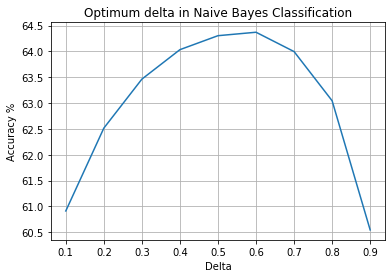

In [ ]:
delta_list = [0.1 , 0.2 , 0.3 , 0.4 , 0.5 ,0.6 , 0.7 , 0.8 , 0.9]
acc_list = []
for d in delta_list : 
    B_NB = Naive_Bayes_Bigram_Classifier(bigrams_set , delta = d)
    B_NB.train(train_data)
    acc , pred = B_NB.score(val_data)
    acc_list.append(acc)

acc_list = [x*100 for x in acc_list]
fig, ax = plt.subplots()
ax.plot(delta_list , acc_list )
ax.set(xlabel='Delta', ylabel='Accuracy %',
       title='Optimum delta in Naive Bayes Classification')
ax.grid()
plt.show()

accuracy of model on test data

In [ ]:
B_NB = Naive_Bayes_Bigram_Classifier(bigrams_set , delta = 0.6)
B_NB.train(train_data)
acc , pred = B_NB.score(test_data)
print( 'Accuracy of Naive Bayes Classifier with delta= 0.6  is  {:4.2f} % '.format( acc * 100 ))

Accuracy of Naive Bayes Classifier with delta= 0.6  is  63.40 % 


# Section 5

In [ ]:
NB = Naive_Bayes_Bigram_Classifier(bigrams_set , delta = 0.6)
NB.train(train_data)
acc , pred = NB.score(test_data)
print( 'Accuracy of Naive Bayes Classifier with delta= 0.6  is  {:4.2f} % '.format( acc * 100 ))

Accuracy of Naive Bayes Classifier with delta= 0.6  is  63.40 % 


Confusion matrix of bigram naive bayes **classifier**

In [ ]:
print(NB.labels)
print('      ')
NB.confusion_matrix

['moulavi', 'amir', 'sanaee', 'ghaani', 'bahar', 'khosro']
      


array([[1718.,   64.,  371.,   77.,   54.,  279.],
       [  53., 1426.,  193.,  118.,   44.,   81.],
       [ 339.,  207., 1432.,  168.,   98.,  257.],
       [ 120.,  162.,  245., 1231.,  102.,  201.],
       [ 247.,  158.,  310.,  211.,  944.,  234.],
       [ 141.,   68.,  192.,   91.,   56., 1808.]])

## section 5-1

eddited prepare_data function

In [ ]:
def prepare2_data(add , labels):
    data= {'all': {'bigrams' : [] , 'unigrams' : [] ,'beyt' : [] , 'bigram_count':{} , 'unigram_count':{} }}
    poets = []
    with open( add ,  encoding = 'UTF-8') as file:
        data_lines = file.readlines()
    for i in range(0,len(data_lines) , 3):
        if (data_lines[i][:-1] not in poets) and (data_lines[i][:-1] in labels) : 
            poets.append(data_lines[i][:-1])
            data[data_lines[i][:-1]] = {'bigrams' : [] , 'unigrams' : [] ,'beyt' : [] , 
                                        'bigram_count':{} , 'unigram_count':{} }
        if data_lines[i][:-1] in labels :
            data[data_lines[i][:-1]]['beyt'] += [[data_lines[i+1][:-1] , data_lines[i+2][:-1]]]
            data['all']['beyt'] += [[data_lines[i+1][:-1] , data_lines[i+2][:-1]]]

            tokens =[]
            tokens += word_tokenize(data_lines[i+1][:-1])
            tokens += word_tokenize(data_lines[i+2][:-1])
            tokens_set = list(set(tokens))
            for w in tokens_set:
                if w in data['all']['unigram_count']:
                    data['all']['unigram_count'][w] +=1
                else :
                    data['all']['unigram_count'][w] =1

                if w in data[data_lines[i][:-1]]['unigram_count']:
                    data[data_lines[i][:-1]]['unigram_count'][w] +=1
                else: 
                    data[data_lines[i][:-1]]['unigram_count'][w] =1

            data[data_lines[i][:-1]]['unigrams'] += tokens
            data['all']['unigrams'] += tokens

            for mes in range(2):
                tokens =[]
                tokens += word_tokenize(data_lines[i+1+mes][:-1])
                for idx in range(len(tokens)-1):
                    new_bi = tokens[idx] + ' ' + tokens[idx+1]
                    if new_bi in data['all']['bigram_count']:
                        data['all']['bigram_count'][new_bi] +=1
                    else :
                        data['all']['bigram_count'][new_bi] =1

                    if new_bi in data[data_lines[i][:-1]]['bigram_count']:
                        data[data_lines[i][:-1]]['bigram_count'][new_bi] +=1
                    else: 
                        data[data_lines[i][:-1]]['bigram_count'][new_bi] =1

                    data[data_lines[i][:-1]]['bigrams'].append(new_bi)
                    data['all']['bigrams'].append(new_bi)
    return data


In [ ]:
train2_data = prepare2_data('/content/drive/MyDrive/nlp/HW1/train.txt' , ['moulavi' , 'sanaee'])
test2_data = prepare2_data('/content/drive/MyDrive/nlp/HW1/test.txt' , ['moulavi' , 'sanaee'])

eddited Naive_Bayes_Bigram_Classifier class

In [ ]:
class Naive_Bayes_Bigram_Classifier():
    def __init__(self , f_set , delta = 0.5   ):
        self.f_set = f_set
        self.delta = delta
        self.labels = ['moulavi','sanaee']
    
    def train (self , data):
        self.data = data
        self.vocab_size = len(list(set(self.data['all']['unigrams'])))
        self.all_vocab = len(self.data['all']['unigrams'])
        
    def predict (self , beyts):
        tok = []
        tok += bigram_line(beyts[0])
        tok += bigram_line(beyts[1])
        self.pred_probs = {'moulavi' : 0 , 'sanaee' : 0 }
        for l in self.labels:
            prob = 1
            c_l = len(self.data[l]['beyt']) / len(self.data['all']['beyt'])
            B=0
            for t in tok:
                try :
                    self.data[l]['bigram_count'][t]
                    B+=1
                except : pass
            for t in tok:
                token = unigram_line(t)
                try: 
                    c_bi = self.data[l]['bigram_count'][t]
                    c_token = self.data[l]['unigram_count'][token[0]]
                    prob *= (c_bi - self.delta) / c_token

                except : 
                    try : 
                        c_unigram = self.data[l]['unigram_count'][token[1]]
                        c_token = 1
                        prob *= (self.delta * B * c_unigram) / (c_token * self.all_vocab)
                    except :
                        prob *= 1 / self.vocab_size

            self.pred_probs[l] = prob * c_l
            
        return self.pred_probs
    
    def score (self , test_d):
        true_lable = 0
        pred_list=[]
        self.confusion_matrix = np.zeros([2,2])
        self.measures = {'moulavi' : {'tp': 0 , 'fp' : 0 , 'fn' : 0  , 'Precision' : 0 , 'recall' : 0, 'f1' : 0}
                         , 'sanaee' : {'tp': 0 , 'fp' : 0 , 'fn' : 0  , 'Precision' : 0 , 'recall' : 0, 'f1' : 0} }
        for l in self.labels:
            for b in test_d[l]['beyt']:
                pred = self.predict(b)
                pred = list(pred.values())
                max_prob = self.labels[np.argmax(pred)]
                pred_list.append(max_prob)
                if max_prob == l : 
                    true_lable += 1
                    self.measures[l]['tp'] +=1
                    self.confusion_matrix[self.labels.index(l),self.labels.index(l)] += 1
                else :
                    self.measures[l]['fn'] +=1
                    self.measures[max_prob]['fp'] +=1 
                    self.confusion_matrix[self.labels.index(l),self.labels.index(max_prob)] += 1
                    
        self.acc = true_lable / len(test_d['all']['beyt'])
        return self.acc , pred_list
            
    def cal_measures(self , avg = 'macro_avreging'):
        for l in self.labels:
            self.measures[l]['precision'] = self.measures[l]['tp'] / (self.measures[l]['tp'] 
                                                                             + self.measures[l]['fp'])
            self.measures[l]['recall'] = self.measures[l]['tp'] / (self.measures[l]['tp'] 
                                                                             + self.measures[l]['fn'])
            self.measures[l]['f1'] = (2*self.measures[l]['precision']*self.measures[l]['recall']) / (self.measures[l]['precision'] + self.measures[l]['recall'])
        precision , recall = 0 , 0
        for l in self.labels:
            if avg == 'macro_avreging': c = 1
            if avg == 'micro_avreging': c = len(self.data[l]['beyt']) / len(self.data['all']['beyt'])
            precision += (c * self.measures[l]['precision'])
            recall += (c * self.measures[l]['recall'])
        precision /= len(self.labels)
        recall /= len(self.labels)
        f1 = (2 * precision * recall) / (precision + recall)
        return precision, recall, f1
 

Accuracy and Confusion Matrix 

In [ ]:
bigrams_set= list(set(train2_data['all']['bigrams']))
bnb = Naive_Bayes_Bigram_Classifier(bigrams_set , delta=0.6 )
bnb.train(train2_data)
acc , pred = bnb.score(test2_data)
print('Accuracy = {:4.2f} % '.format(acc * 100))
print('  ')
print(bnb.confusion_matrix)

Accuracy = 78.55 % 
  
[[1987.  576.]
 [ 510. 1991.]]


## section 5-2

In [ ]:
class Naive_Bayes_Bigram_Classifier():
    def __init__(self , f_set , delta = 0.5):
        self.f_set = f_set
        self.delta = delta
        self.labels = ['moulavi','amir']
    
    def train (self , data):
        self.data = data
        self.vocab_size = len(list(set(self.data['all']['unigrams'])))
        self.all_vocab = len(self.data['all']['unigrams'])
        
    def predict (self , beyts):
        tok = []
        tok += bigram_line(beyts[0])
        tok += bigram_line(beyts[1])
        self.pred_probs = {'moulavi' : 0 , 'amir' : 0 }
        for l in self.labels:
            prob = 1
            c_l = len(self.data[l]['beyt']) / len(self.data['all']['beyt'])
            B=0
            for t in tok:
                try :
                    self.data[l]['bigram_count'][t]
                    B+=1
                except : pass
            for t in tok:
                token = unigram_line(t)
                try: 
                    c_bi = self.data[l]['bigram_count'][t]
                    c_token = self.data[l]['unigram_count'][token[0]]
                    prob *= (c_bi - self.delta) / c_token

                except : 
                    try : 
                        c_unigram = self.data[l]['unigram_count'][token[1]]
                        c_token = 1
                        prob *= (self.delta * B * c_unigram) / (c_token * self.all_vocab)
                    except :
                        prob *= 1 / self.vocab_size

            self.pred_probs[l] = prob * c_l
            
        return self.pred_probs
    
    def score (self , test_d):
        true_lable = 0
        pred_list=[]
        self.confusion_matrix = np.zeros([2,2])
        self.measures = {'moulavi' : {'tp': 0 , 'fp' : 0 , 'fn' : 0  , 'Precision' : 0 , 'recall' : 0, 'f1' : 0}
                         , 'amir' : {'tp': 0 , 'fp' : 0 , 'fn' : 0  , 'Precision' : 0 , 'recall' : 0, 'f1' : 0} }
        for l in self.labels:
            for b in test_d[l]['beyt']:
                pred = self.predict(b)
                pred = list(pred.values())
                max_prob = self.labels[np.argmax(pred)]
                pred_list.append(max_prob)
                if max_prob == l : 
                    true_lable += 1
                    self.measures[l]['tp'] +=1
                    self.confusion_matrix[self.labels.index(l),self.labels.index(l)] += 1
                else :
                    self.measures[l]['fn'] +=1
                    self.measures[max_prob]['fp'] +=1 
                    self.confusion_matrix[self.labels.index(l),self.labels.index(max_prob)] += 1
                    
        self.acc = true_lable / len(test_d['all']['beyt'])
        return self.acc , pred_list
            
    def cal_measures(self , avg = 'macro_avreging'):
        for l in self.labels:
            self.measures[l]['precision'] = self.measures[l]['tp'] / (self.measures[l]['tp'] 
                                                                             + self.measures[l]['fp'])
            self.measures[l]['recall'] = self.measures[l]['tp'] / (self.measures[l]['tp'] 
                                                                             + self.measures[l]['fn'])
            self.measures[l]['f1'] = (2*self.measures[l]['precision']*self.measures[l]['recall']) / (self.measures[l]['precision'] + self.measures[l]['recall'])
        precision , recall = 0 , 0
        for l in self.labels:
            if avg == 'macro_avreging': c = 1
            if avg == 'micro_avreging': c = len(self.data[l]['beyt']) / len(self.data['all']['beyt'])
            precision += (c * self.measures[l]['precision'])
            recall += (c * self.measures[l]['recall'])
        precision /= len(self.labels)
        recall /= len(self.labels)
        f1 = (2 * precision * recall) / (precision + recall)
        return precision, recall, f1
 

In [ ]:
train2_data = prepare2_data('/content/drive/MyDrive/nlp/HW1/train.txt' , ['moulavi' , 'amir'])
test2_data = prepare2_data('/content/drive/MyDrive/nlp/HW1/test.txt' , ['moulavi' , 'amir'])

bigrams_set= list(set(train2_data['all']['bigrams']))
bnb = Naive_Bayes_Bigram_Classifier(bigrams_set , delta=0.6 )
bnb.train(train2_data)
acc , pred = bnb.score(test2_data)
print('Accuracy = {:4.2f} % '.format(acc * 100))
print('  ')
print(bnb.confusion_matrix)

Accuracy = 91.85 % 
  
[[2343.  220.]
 [ 145. 1770.]]


## section 5-3

In [ ]:
class Naive_Bayes_Bigram_Classifier():
    def __init__(self , f_set , delta = 0.5):
        self.f_set = f_set
        self.delta = delta
        self.labels = ['bahar','ghaani']
    
    def train (self , data):
        self.data = data
        self.vocab_size = len(list(set(self.data['all']['unigrams'])))
        self.all_vocab = len(self.data['all']['unigrams'])
        
    def predict (self , beyts):
        tok = []
        tok += bigram_line(beyts[0])
        tok += bigram_line(beyts[1])
        self.pred_probs = {'bahar' : 0 , 'ghaani' : 0 }
        for l in self.labels:
            prob = 1
            c_l = len(self.data[l]['beyt']) / len(self.data['all']['beyt'])
            B=0
            for t in tok:
                try :
                    self.data[l]['bigram_count'][t]
                    B+=1
                except : pass
            for t in tok:
                token = unigram_line(t)
                try: 
                    c_bi = self.data[l]['bigram_count'][t]
                    c_token = self.data[l]['unigram_count'][token[0]]
                    prob *= (c_bi - self.delta) / c_token

                except : 
                    try : 
                        c_unigram = self.data[l]['unigram_count'][token[1]]
                        c_token = 1
                        prob *= (self.delta * B * c_unigram) / (c_token * self.all_vocab)
                    except :
                        prob *= 1 / self.vocab_size

            self.pred_probs[l] = prob * c_l
            
        return self.pred_probs
    
    def score (self , test_d):
        true_lable = 0
        pred_list=[]
        self.confusion_matrix = np.zeros([2,2])
        self.measures = {'bahar' : {'tp': 0 , 'fp' : 0 , 'fn' : 0  , 'Precision' : 0 , 'recall' : 0, 'f1' : 0}
                         , 'ghaani' : {'tp': 0 , 'fp' : 0 , 'fn' : 0  , 'Precision' : 0 , 'recall' : 0, 'f1' : 0} }
        for l in self.labels:
            for b in test_d[l]['beyt']:
                pred = self.predict(b)
                pred = list(pred.values())
                max_prob = self.labels[np.argmax(pred)]
                pred_list.append(max_prob)
                if max_prob == l : 
                    true_lable += 1
                    self.measures[l]['tp'] +=1
                    self.confusion_matrix[self.labels.index(l),self.labels.index(l)] += 1
                else :
                    self.measures[l]['fn'] +=1
                    self.measures[max_prob]['fp'] +=1 
                    self.confusion_matrix[self.labels.index(l),self.labels.index(max_prob)] += 1
                    
        self.acc = true_lable / len(test_d['all']['beyt'])
        return self.acc , pred_list
            
    def cal_measures(self , avg = 'macro_avreging'):
        for l in self.labels:
            self.measures[l]['precision'] = self.measures[l]['tp'] / (self.measures[l]['tp'] 
                                                                             + self.measures[l]['fp'])
            self.measures[l]['recall'] = self.measures[l]['tp'] / (self.measures[l]['tp'] 
                                                                             + self.measures[l]['fn'])
            self.measures[l]['f1'] = (2*self.measures[l]['precision']*self.measures[l]['recall']) / (self.measures[l]['precision'] + self.measures[l]['recall'])
        precision , recall = 0 , 0
        for l in self.labels:
            if avg == 'macro_avreging': c = 1
            if avg == 'micro_avreging': c = len(self.data[l]['beyt']) / len(self.data['all']['beyt'])
            precision += (c * self.measures[l]['precision'])
            recall += (c * self.measures[l]['recall'])
        precision /= len(self.labels)
        recall /= len(self.labels)
        f1 = (2 * precision * recall) / (precision + recall)
        return precision, recall, f1
 

In [ ]:
train2_data = prepare2_data('/content/drive/MyDrive/nlp/HW1/train.txt' , ['bahar' , 'ghaani'])
test2_data = prepare2_data('/content/drive/MyDrive/nlp/HW1/test.txt' , ['bahar' , 'ghaani'])

bigrams_set= list(set(train2_data['all']['bigrams']))
bnb = Naive_Bayes_Bigram_Classifier(bigrams_set , delta=0.6 )
bnb.train(train2_data)
acc , pred = bnb.score(test2_data)
print('Accuracy = {:4.2f} % '.format(acc * 100))
print('  ')
print(bnb.confusion_matrix)

Accuracy = 79.76 % 
  
[[1538.  566.]
 [ 277. 1784.]]
